# Forecasting Cancellations

---


---

# Imports

In [1]:
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pmd
from pmdarima.arima import AutoARIMA, ndiffs, nsdiffs
from pmdarima.model_selection import train_test_split
from pmdarima.preprocessing import BoxCoxEndogTransformer, FourierFeaturizer
from pmdarima.pipeline import Pipeline
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn import metrics

In [2]:
## Reading data and setting DT index
path = '../../data/3.3_data_exploded.feather'
data = pd.read_feather(path)
data = data.sort_values('Stay Date')
data = data.set_index('Stay Date')
data

,IsCanceled,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,...,ArrivalDate_DaysBeforeHoliday,ArrivalDate_DaysAfterHoliday,DepartureDate_DaysBeforeHoliday,DepartureDate_DaysAfterHoliday,BookingDate_DaysBeforeHoliday,BookingDate_DaysAfterHoliday,ArrivalWeek,ArrivalDay,ArrivalDateDayName,ArrivalDateMonthName
Stay Date,,,,,,,,,,,,,,,,,,,,,
2015-07-01,0,1,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,...,45,21,43,23,51,15,27,3,Wednesday,July
2015-07-01,0,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,...,45,21,43,23,52,63,27,3,Wednesday,July
2015-07-01,0,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,...,45,21,43,23,52,63,27,3,Wednesday,July
2015-07-01,0,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,...,45,21,43,23,52,63,27,3,Wednesday,July
2015-07-01,0,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,...,45,21,43,23,52,63,27,3,Wednesday,July
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-11,0,2,0.0,0,BB,IRL,Direct,Direct,0,0,...,37,14,23,28,67,36,35,2,Tuesday,August
2017-09-12,0,2,0.0,0,HB,DEU,Offline TA/TO,TA/TO,0,0,...,35,16,21,30,22,81,35,4,Thursday,August
2017-09-12,0,2,0.0,0,HB,GBR,Offline TA/TO,TA/TO,0,0,...,35,16,21,30,72,31,35,4,Thursday,August


In [4]:
data['ReservationStatus'].value_counts()

ReservationStatus
Check-Out    255040
Canceled     149740
No-Show        4477
Name: count, dtype: int64

In [7]:
data.loc[:, 'ReservationStatus'] = np.where(data['ReservationStatus'] == 'No-Show', 'Canceled', data['ReservationStatus'])
data.loc[:, 'ReservationStatus']

Stay Date
2015-07-01    Check-Out
2015-07-01    Check-Out
2015-07-01    Check-Out
2015-07-01    Check-Out
2015-07-01    Check-Out
                ...    
2017-09-11    Check-Out
2017-09-12    Check-Out
2017-09-12    Check-Out
2017-09-13    Check-Out
2017-09-13    Check-Out
Name: ReservationStatus, Length: 409257, dtype: object

In [10]:
data['ReservationStatus'].value_counts(normalize=True).round(2)

ReservationStatus
Check-Out    0.62
Canceled     0.38
Name: proportion, dtype: float64

In [19]:
res_statuses = pd.DataFrame(data['ReservationStatus'])
res_statuses

,ReservationStatus
Stay Date,
2015-07-01,Check-Out
2015-07-01,Check-Out
2015-07-01,Check-Out
2015-07-01,Check-Out
2015-07-01,Check-Out
...,...
2017-09-11,Check-Out
2017-09-12,Check-Out
2017-09-12,Check-Out


In [26]:
## Group by date and reservation status
result = res_statuses.groupby(res_statuses.index).value_counts()
result_unstacked = result.unstack(fill_value=0)
result_unstacked

ReservationStatus,Canceled,Check-Out
Stay Date,,
2015-07-01,19,101
2015-07-02,76,130
2015-07-03,85,94
2015-07-04,85,130
2015-07-05,77,134
...,...,...
2017-09-09,2,7
2017-09-10,2,3
2017-09-11,0,3


<Axes: xlabel='Stay Date'>

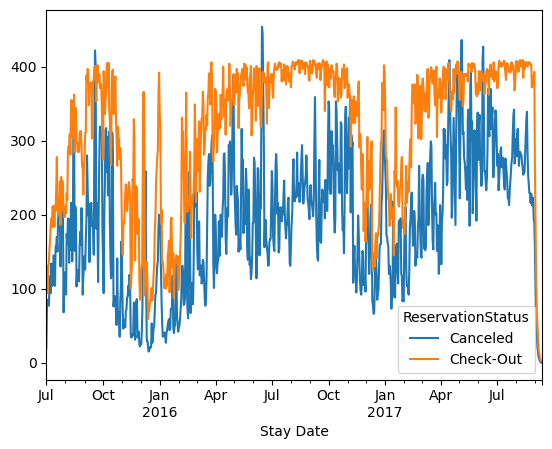

In [27]:
result_unstacked.plot();